In [20]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from util import string_to_yuan,string_to_month

# df = pd.read_json('./sample_p4.txt', encoding='gb18030', lines=True)
# df.dropna(axis=0, subset=['content'], inplace=True)
# print('非空:', len(df))
# df = df.iloc[np.bitwise_and(
#     df['trial_round'].values != '其他', df['trial_round'].values != '刑罚变更'), :]
# print('非其他，非刑法变更:', len(df))
# df = df.iloc[df['content'].apply(is_valid).values, :]
# print('非撤回上诉:', len(df))
# contents = df['content'].values

df = pd.read_csv('res.csv')
df.dropna(axis=0, subset=['事实认定','审理意见','判决结果'], inplace=True)

money = []
cnt = 1


def is_valid(t):
    if t.find('撤回上诉') != -1:
        return False
    if t.find('重新审判') != -1:
        return False
    if t.find("申诉理由不能成立") != -1:
        return False
    return True


def get_money(t: str):
    ret = []

    m = re.findall(f"(?<=追缴赃款).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=违法所得).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=所得赃款).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=收受的).*?(?=赃款依法予以没收)", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=收受的).*?(?=上缴)", t, re.M)
    ret.extend(m)
    
    rret = []
    for t in ret:
        if re.search('[，。；,.、]',t):
            continue
        rret.append(t)
    ret = rret
    
    if len(ret)==0:
        m = re.findall("(?<=共计).*?元",t,re.S)
        ret.extend(m)
        
        m = re.findall("(?<=总计).*?元",t,re.S)
        ret.extend(m)
        
        m = re.findall("(?<=计).*?元",t,re.S)
        ret.extend(m)
    
    rret = []
    for t in ret:
        if re.search('[，。；,.、]',t):
            # print(t)
            continue
        rret.append(t)
    ret = rret
    
    # return ret[0:1]
    
    if len(ret) == 0:
        m = re.findall(f"[\d零一二三四五六七八九十百千万]*元", t, re.M)
        ret.extend(m)
    
    return ret

def money_clear(m:str):
    try:
        return re.search('[\d零一二三四五六七八九十百千万]*元',m).group(0)
    except:
        return m

def select_fact(t:str):
    ret = []
    facts = re.findall("(?<=认证的下列证据予以证实：\n).*?(?=以上)",t,re.DOTALL)
    for fact in facts:
        f0 = fact.split('\n')[0]
        ret.append(f0)
    return ''.join(ret)

def sum_money(m):
    ret = 0
    for t in m:
        t = money_clear(t)
        try:
            ret += string_to_yuan(t)
        except:
            # print(t)
            # break
            pass
    return ret

contents = df['审理意见'].values

for text in contents:
    # fact = select_fact(text)
    fact = None
    if fact:
        m = get_money(fact)
    else:
        m = get_money(text)
    money.append(m)
    
print('金额提取成功比例',np.sum([len(m)!=0 for m in money])/len(money),len(money))
result = []
for m in tqdm(money):
    result.append(sum_money(m))
        
# cnt= 0
# for idx,m in enumerate(money):
#     if len(m)==0:
#         print(idx)
#         print(m)
#         print(df.iloc[idx]['content'])
#         cnt+=1
#     if cnt>10:
#         break


金额提取成功比例 0.7289538569918985 17034


100%|██████████| 17034/17034 [00:09<00:00, 1739.33it/s]


In [21]:
# for i in range(10000):
#     if result[i]!=0:
#         print(i,result[i],df.iloc[i]['审理意见'])

In [22]:
def time_clear(m:str):
    try:
        return re.search('[\d零一二三四五六七八九十个年月]*',m).group(0)
    except:
        return m

def get_month(month):
    try:
        return string_to_month(time_clear(month))
    except:
        return 0

df['金额'] = result
df['金额'].replace(0,np.nan,inplace=True)
df['有期徒刑'] = df['有期徒刑'].apply(get_month)
df['缓刑'] = df['缓刑'].apply(get_month)

In [23]:
df.dropna(axis=0, subset=['罚金','有期徒刑'], how ='all',inplace=True)
df.dropna(axis=0, subset=['金额'], inplace=True)
df.head()
# df.to_csv('res1.csv',index=False)

,index,事实认定,审理意见,判决结果,量刑,量刑全文,长度,金额,罪名,有期徒刑,缓刑,罚金,免罪
0,3644.txt,，2007年至2011年间，被告人卓天双利用其担任桐林监狱监狱长的职务便利，在桐林监狱迁建梧...,，被告人卓天双身为国家工作人员，利用职务上的便利，非法收受他人人民币41万元，为他人谋取利益...,：一、被告人卓天双犯受贿罪，判处有期徒刑三年三个月，并处罚金人民币二十八万元；（刑期从判决执...,"['：一、被告人卓天双犯受贿罪', '判处有期徒刑三年三个月', '并处罚金人民币二十八万元...",：一、被告人卓天双犯受贿罪，判处有期徒刑三年三个月，并处罚金人民币二十八万元；（刑期从判决执...,3,1740000.0,受贿,39.0,0.0,280000.0,NaN
2,5235.txt,：2013年11月至案发，被告人龙开泉担任雅安市名山区水务局局长。龙开泉在其任职期间，利用职...,，被告人龙开泉身为国家工作人员，利用职务之便，非法收受他人财物230万元，数额巨大，并为他人...,：一、被告人龙开泉犯受贿罪，判处有期徒刑七年，并处罚金人民币三十万元。（刑期自判决执行之日起...,"['：一、被告人龙开泉犯受贿罪', '判处有期徒刑七年', '并处罚金人民币三十万元']",：一、被告人龙开泉犯受贿罪，判处有期徒刑七年，并处罚金人民币三十万元,3,2300000.0,受贿,84.0,0.0,300000.0,NaN
3,1053.txt,：2011年冬季征兵期间，刘绪树为了让其子刘晓龙顺利入伍，在被告人翟某办公室送给翟某人民币现...,，被告人翟某身为鄂州市梁子湖区梁子镇党委委员、武装部长，在其负责梁子镇征兵过程中，利用职务便...,：被告人翟某犯受贿罪，判处免予刑事处罚。如不服本判决，可在接到判决书的第二日起十日内，通过本...,"['：被告人翟某犯受贿罪', '判处免予刑事处罚']",：被告人翟某犯受贿罪，判处免予刑事处罚,2,5500.0,受贿,0.0,0.0,NaN,NaN
4,13514.txt,：2010年8月，时任焦作电厂经营策划部部长的被告人孙某某，利用担任经营策划部主任负责处理王...,，被告人孙某某身为国有公司从事公务的人员，利用职务上的便利，非法收受他人现金5万元，为他人谋...,：被告人孙某某犯受贿罪，免予刑事处罚。如不服本判决，可在接到判决书的第二日起十日内，通过本院...,"['：被告人孙某某犯受贿罪', '免予刑事处罚']",：被告人孙某某犯受贿罪，免予刑事处罚,2,50000.0,受贿,0.0,0.0,NaN,NaN
5,15165.txt,：被告人陈某于2012年至2014年任宿州市教育体育局（以下简称宿州市教体局）装备中心负责人...,：被告人陈某利用职务之便，为他人谋取利益，收受财物12万元，数额较大，其行为构成受贿罪。公诉...,：一、被告人陈某犯受贿罪，判处有期徒刑一年，并处罚金十二万元（罚金已交纳）。（刑期从判决执行...,"['：一、被告人陈某犯受贿罪', '判处有期徒刑一年', '并处罚金十二万元（罚金已交纳）']",：一、被告人陈某犯受贿罪，判处有期徒刑一年，并处罚金十二万元（罚金已交纳）,3,120000.0,受贿,12.0,0.0,20000.0,NaN


array([[1.        , 0.17065552],
       [0.17065552, 1.        ]])

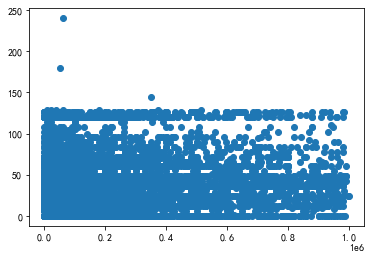

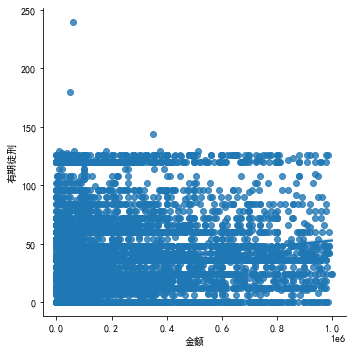

In [24]:
# df = pd.read_csv('res1.csv')

# values = df['金额'].values
# l = values.mean()-values.std()
# r = values.mean()+values.std()

# idx = np.logical_and(l < values,values < 1e6)
# df = df.iloc[idx,:]


from pylab import mpl
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# df.plot.scatter(x='金额',y='有期徒刑')
# df.plot.line(x='金额',y='有期徒刑')

# print(values.mean())
import seaborn as sns
import matplotlib.pyplot as plt
# sns.lineplot(x='金额',y='有期徒刑',data=df)

x = df['金额'].values
y = df['有期徒刑'].values

idx = x<1e6

x = x[idx]
y = y[idx]

plt.scatter(x,y)

dff = pd.DataFrame(data=np.array([x,y]).T,columns=['金额','有期徒刑'])
sns.lmplot(x='金额',y='有期徒刑',data=dff)
np.corrcoef(x,y)

In [25]:
df.to_csv('res_lg.csv',index=False)
# df.head()
